## Procesamiento de Lenguaje Natural

*Proyecto Final: **Modelado de Tópicos*** 

# ***Análisis exploratorio de datos***

### **Equipo:**

- Giottonini Herrera Enrique Alejandro
- Burruel Durán Luis Andrés
- Villalba Miranda Jesús Abraham
- Oscar

**Fuentes**
* Los datos fueron obtenidos de [@nostradata ](https://www.nostrodata.com) en [`GitHub`](https://github.com/NOSTRODATA/conferencias_matutinas_amlo)
---

In [1]:
# Importamos las librerias que utilizaremos
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from matplotlib import pyplot as plt

## **Objetivo**

El propósito es realizar un análisis exploratorio sobre los datos crudos para tener una base en la toma de desiciones con respecto al pre-procesamiento de datos (limpieza, normalización, etc.) para nuestra tarea final, el `modelado de topicos`.

Es importante señalar la estructura de los documentos o datos crudos que estaremos analizando y que formato deseamos como resultado del preprocesamiento para el entrenamiento del modelo que utilizaremos para el modelado de topicos. Los documentos vienen separados en archivos diferentes, en el que cada archivo contiene las mañaneras ocurridas en la semana correspondiente.

Lo que esperamos producir como salida es un archivo `csv` que contenga los **tokens** identificados de la semana despues del preprocesamiento del texto.

### Extracción de información de los archivos

In [2]:
def getData(filename: str) -> str:
    """ Lee y almacena en un string todos los carácteres leídos en un archivo .txt """
    rawData = ""
    with open(filename, encoding="utf-8") as f:
        for line in f:
            rawData += line
    return rawData

In [3]:
available_data_paths = os.listdir(path='../data/')

Para la tarea que estamos resolviendo consideramos pertinente analizar nuestro corpus realizando un preprocesamiento sencillo de convertir todos nuestros caracteres alfanumericos a minusculas.

In [4]:
df = pd.DataFrame(columns=['text', 'week'])
for file_name in available_data_paths:
    df.loc[len(df)] = [getData(f'../data/{file_name}').lower(), file_name]

In [5]:
df.shape

(219, 2)

## Estadisticas simples

En esta sección analizaremos información basica de nuestros documentos, como la cantidad de palabras por documento, cantidad de sentencias por documento, etc. 

In [10]:
eda_df = df.copy()
eda_df['words'] = df['text'].apply(lambda x: word_tokenize(x, 'spanish'))
eda_df['sentences'] = df['text'].apply(lambda x: sent_tokenize(x, 'spanish'))
eda_df['num_ch'] = df['text'].apply(lambda x: len(x))

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/spanish.pickle[0m

  Searched in:
    - 'C:\\Users\\Lenovo/nltk_data'
    - 'c:\\Python\\Python310\\nltk_data'
    - 'c:\\Python\\Python310\\share\\nltk_data'
    - 'c:\\Python\\Python310\\lib\\nltk_data'
    - 'C:\\Users\\Lenovo\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [45]:
eda_df.head()

,text,week,words,sentences,num_ch
0,"buenos días.bueno, iniciamos la semana como s...",01-03-2021.txt,"[buenos, días.bueno, ,, iniciamos, la, semana,...","[ buenos días.bueno, iniciamos la semana como ...",338181
1,"buenos días. ánimo, estamos iniciando la sema...",01-04-2019.txt,"[buenos, días, ., ánimo, ,, estamos, iniciando...","[ buenos días., ánimo, estamos iniciando la se...",229694
2,"buenos días.el día de hoy aquí, en quintana r...",01-06-2020.txt,"[buenos, días.el, día, de, hoy, aquí, ,, en, q...","[ buenos días.el día de hoy aquí, en quintana ...",157275
3,buenos días.es una semana que estamos inician...,01-07-2019.txt,"[buenos, días.es, una, semana, que, estamos, i...",[ buenos días.es una semana que estamos inicia...,104749
4,"buenos días.ánimo, ánimo, estamos comenzando ...",01-08-2022.txt,"[buenos, días.ánimo, ,, ánimo, ,, estamos, com...","[ buenos días.ánimo, ánimo, estamos comenzando...",280983


#### Número de caracteres por documento (semana)

In [11]:
plt.hist(eda_df['num_ch'])
plt.title('Número de caracteres por documento.')
plt.xlabel('Número de caracteres')
plt.ylabel('Documentos')
plt.show()

KeyError: 'num_ch'

#### Número de palabras por semana.

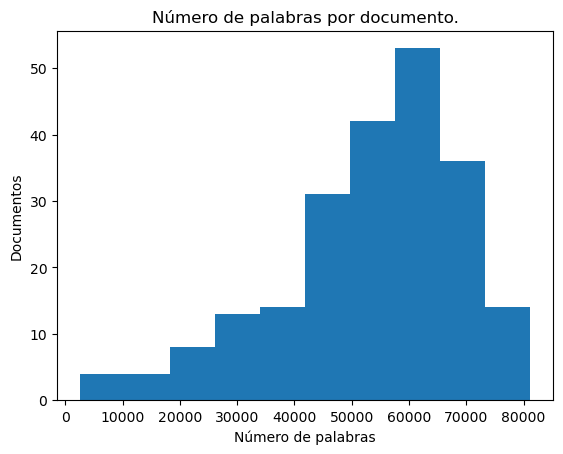

In [47]:
plt.hist(eda_df['words'].apply(lambda x: len(x)))
plt.title('Número de palabras por documento.')
plt.xlabel('Número de palabras')
plt.ylabel('Documentos')
plt.show()

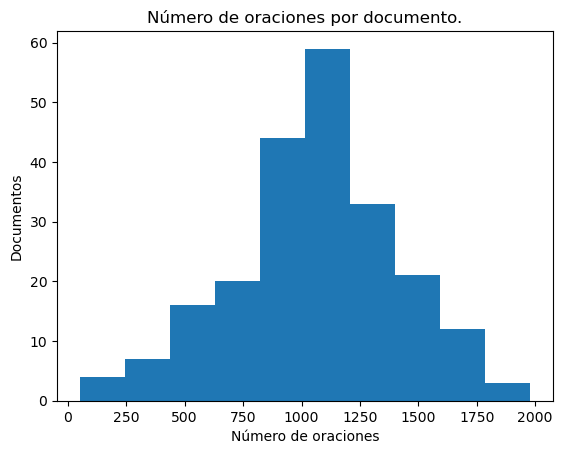

In [48]:
plt.hist(eda_df['sentences'].apply(lambda x: len(x)))
plt.title('Número de oraciones por documento.')
plt.xlabel('Número de oraciones')
plt.ylabel('Documentos')
plt.show()

#### Longitud promedio de palabras por documento.

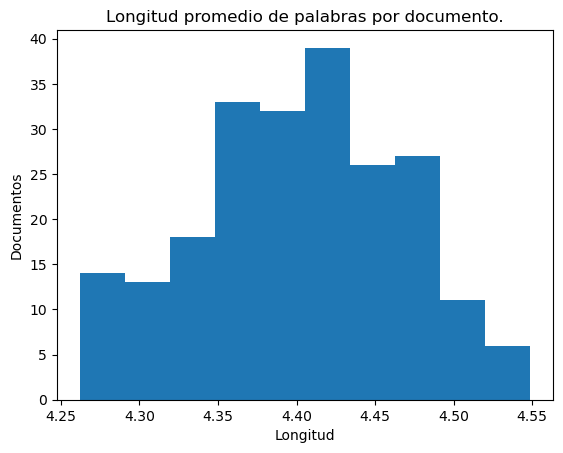

In [49]:
plt.hist(eda_df['words'].apply(lambda x: np.mean([len(i) for i in x])))
plt.title('Longitud promedio de palabras por documento.')
plt.xlabel('Longitud')
plt.ylabel('Documentos')
plt.show()

## Palabras más repetidas.

Para realizar este analisis y considerando la tarea que queremos realizar, consideramos pertinente realizar un preprocesamiento basico de nuestro corpus antes de obtener las palabras más repetidas de nuestro corpus. 

El preprocesamiento que consideramos pertinente es:
 * Quedarnos solamente con caracteres alfanumericos.
 * Remover `stopwords`.

In [50]:
stop_words = stopwords.words('spanish')

In [51]:
clean_word = lambda word: re.sub(r'[^\w]','', word)

def basic_preprocessing(text: str) -> str:
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [clean_word(word) for word in tokens if word] 
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [52]:
eda_df['clean'] =  eda_df['text'].apply(basic_preprocessing)
print(eda_df[['clean']].head())

                                               clean
0  buenos díasbueno  iniciamos semana siempre  lu...
1  buenos días  ánimo  iniciando semanaestuvimos ...
2  buenos díasel día hoy aquí  quintana roo  terr...
3  buenos díases semana iniciando ayer pudo tener...
4  buenos díasánimo  ánimo  comenzando semana  lu...


In [53]:
vocab = defaultdict(int)

In [54]:
for text in eda_df['clean']:
    for word in word_tokenize(text): 
        vocab[word] += 1

Ahora que tenemos nuestro vocabulario, lo que haremos será ordenarlo de manera decresiente para obtener los tokens más frecuentes.

In [56]:
s_vocab = sorted(vocab.items(), key = lambda x: x[1], reverse = True)

In [71]:
limit = 20

In [72]:
words, freq = [], []
for word, f in s_vocab[:limit]:
    words.append(word)
    freq.append(f)

[Text(0.5, 1.0, 'Palabras más frecuentes dentro del corpus')]

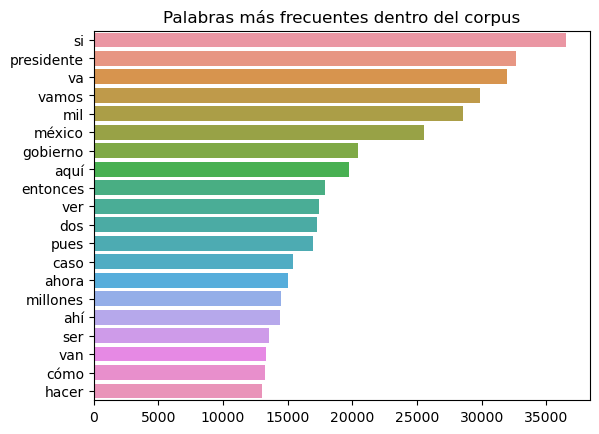

In [74]:
sns.barplot(x=freq, y=words).set(title="Palabras más frecuentes dentro del corpus")

## Bigramas más frecuentes

In [ ]:
top_bigrams=get_top_ngram(word_tokenize(text, 'spanish', True),n=2)
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

## Trigramas más frecuentes

In [ ]:
top_trigrams=get_top_ngram(word_tokenize(text, 'spanish', True),n=3)
x,y=map(list,zip(*top_trigrams))
sns.barplot(x=y,y=x)